# Preparations

In [28]:
!pip install sktime
!pip install dtaidistance

In [29]:
import warnings
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from google.colab import drive
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
df = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_train.csv")
print(df.shape)
df.head()

(857831, 10)


,date,start_station_name,start_station_id,total_rides,temp_min_c,rain_sum_mm,snowfall_sum_cm,month,dayofweek,year
0,2020-01-01,63rd St Beach,101,2,-5.5,0.0,0.0,1,2,2020
1,2020-01-01,Orleans St & Hubbard St,636,5,-5.5,0.0,0.0,1,2,2020
2,2020-01-01,Orleans St & Elm St,23,3,-5.5,0.0,0.0,1,2,2020
3,2020-01-01,Orleans St & Chestnut St (NEXT Apts),620,5,-5.5,0.0,0.0,1,2,2020
4,2020-01-01,Ogden Ave & Roosevelt Rd,434,2,-5.5,0.0,0.0,1,2,2020


# Data Preprocessing

In [31]:
station_df = df[["date", "start_station_name", "total_rides"]].groupby(["date", "start_station_name"]).sum().reset_index()
station_df.head()


,date,start_station_name,total_rides
0,2020-01-01,63rd St Beach,2
1,2020-01-01,900 W Harrison St,1
2,2020-01-01,Aberdeen St & Jackson Blvd,2
3,2020-01-01,Aberdeen St & Monroe St,7
4,2020-01-01,Aberdeen St & Randolph St,3


In [32]:
print(len(station_df["start_station_name"].unique()))

2079


## Fill no ridership dates with 0

In [33]:
# prompt: make start_station as variables, total_rides as value, and date as row

# Create a pivot table
station_pivot = station_df.pivot(index='date', columns='start_station_name', values='total_rides').fillna(0)

# Display the resulting pivot table
station_pivot.head()


start_station_name,10101 S Stony Island Ave,111th St - Morgan Park Metra,2112 W Peterson Ave,351,410,532 E 43rd St,63rd & Western Ave - north corner,63rd & Western Ave - south corner,63rd St Beach,83rd St (Avalon Park) Metra,...,Woodlawn & 103rd - Olive Harvey Vaccination Site,Woodlawn Ave & 55th St,Woodlawn Ave & 58th St,Woodlawn Ave & 75th St,Woodlawn Ave & Lake Park Ave,Yale Ave & 119th St,Yates Blvd & 75th St,Yates Blvd & 93rd St,Yates Blvd & Exchange Ave,Zapata Academy
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Cluster on 2021 Data

## Hierarchical Clustering

In [34]:
train = station_pivot.loc["2021-01-01":"2021-12-31"]
test = station_pivot.loc["2022-01-01":"2022-12-31"]
train.head()

start_station_name,10101 S Stony Island Ave,111th St - Morgan Park Metra,2112 W Peterson Ave,351,410,532 E 43rd St,63rd & Western Ave - north corner,63rd & Western Ave - south corner,63rd St Beach,83rd St (Avalon Park) Metra,...,Woodlawn & 103rd - Olive Harvey Vaccination Site,Woodlawn Ave & 55th St,Woodlawn Ave & 58th St,Woodlawn Ave & 75th St,Woodlawn Ave & Lake Park Ave,Yale Ave & 119th St,Yates Blvd & 75th St,Yates Blvd & 93rd St,Yates Blvd & Exchange Ave,Zapata Academy
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-01-02,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2021-01-03,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-01-04,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Get top station

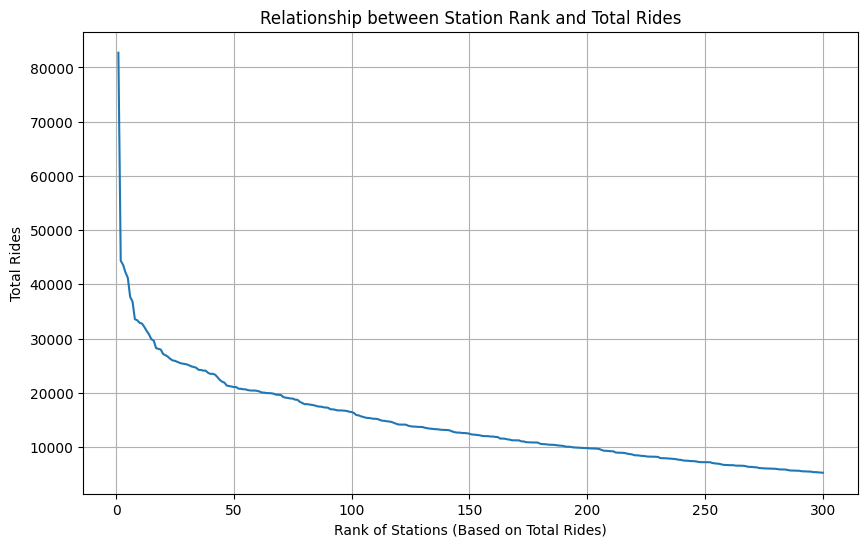

In [74]:
# prompt: Put low frequency station in a cluster in trainset
high_freq_stations = train.sum().sort_values(ascending=False)[:300].index
train_highfreq = train.loc[:, high_freq_stations]
# prompt: plot the relationship between limit for top stations and total ride sum

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_highfreq.columns) + 1), train_highfreq.sum().sort_values(ascending=False))
plt.xlabel('Rank of Stations (Based on Total Rides)')
plt.ylabel('Total Rides')
plt.title('Relationship between Station Rank and Total Rides')
plt.grid(True)
plt.show()

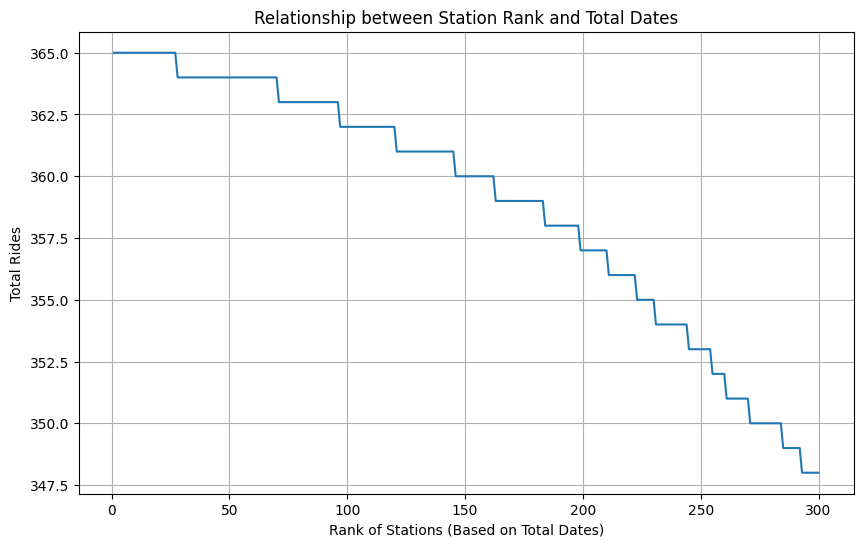

In [80]:
# prompt: Put low frequency station in a cluster in trainset
high_freq_stations = train[train>0].count().sort_values(ascending=False)[:300].index
train_highfreq = train.loc[:, high_freq_stations]
# prompt: plot the relationship between limit for top stations and total ride sum

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_highfreq.columns) + 1), train_highfreq[train_highfreq>0].count().sort_values(ascending=False))
plt.xlabel('Rank of Stations (Based on Total Dates)')
plt.ylabel('Total Rides')
plt.title('Relationship between Station Rank and Total Dates')
plt.grid(True)
plt.show()

### Normalization

In [36]:
# Normalize each station's time series
means = train_highfreq.mean()
stds = train_highfreq.std()
normalized_train_highfreq = ((train_highfreq - means) / stds).dropna(axis=1)
normalized_train_highfreq.head()

start_station_name,Streeter Dr & Grand Ave,Michigan Ave & Oak St,Wells St & Concord Ln,Millennium Park,Clark St & Elm St,Wells St & Elm St,Theater on the Lake,Kingsbury St & Kinzie St,Clark St & Lincoln Ave,Clark St & Armitage Ave,...,Clark St & Ida B Wells Dr,California Ave & Cortez St,Racine Ave & Washington Blvd,Emerald Ave & 31st St,Lincoln Ave & Waveland Ave,Damen Ave & Clybourn Ave,Calumet Ave & 33rd St,Blackstone Ave & Hyde Park Blvd,Ashland Ave & Lake St,Wolcott (Ravenswood) Ave & Montrose Ave
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,-0.850055,-0.943471,-1.224598,-1.040226,-1.394025,-1.336882,-0.893967,-1.522229,-1.048511,-1.131929,...,-1.339751,-1.425078,-1.238169,-1.320420,-1.436398,-1.381870,-1.312256,-1.334630,-0.909615,-1.320627
2021-01-02,-0.842314,-0.943471,-1.050401,-0.874055,-1.295384,-1.152505,-0.814253,-1.618569,-1.000556,-0.954955,...,-1.339751,-0.953754,-1.048321,-1.320420,-1.052938,-1.194263,-1.415349,-1.228753,-0.909615,-1.418880
2021-01-03,-0.838443,-0.935642,-1.039514,-0.938677,-1.267201,-1.109956,-0.831967,-1.387352,-0.928623,-1.036635,...,-1.441395,-1.142284,-1.238169,-1.016412,-0.861209,-1.100459,-1.312256,-1.016999,-0.909615,-1.124121
2021-01-04,-0.842314,-0.888664,-1.181049,-1.058689,-1.168560,-1.464528,-0.849681,-1.194672,-0.928623,-0.927728,...,-0.933175,-1.142284,-0.953398,-1.117748,-0.957073,-1.100459,-1.209162,-1.016999,-0.784305,-1.418880
2021-01-05,-0.842314,-0.912153,-1.017739,-0.920213,-1.239018,-1.365248,-0.849681,-1.136868,-0.904645,-0.954955,...,-0.831531,-1.236548,-1.048321,-1.219084,-0.861209,-0.912852,-1.002975,-0.911122,-0.596340,-1.320627


### Distance Matrix

In [37]:
distance_matrix = dtw.distance_matrix_fast(normalized_train_highfreq.T.to_numpy(),
                      parallel=True)


### Silhoutte Score

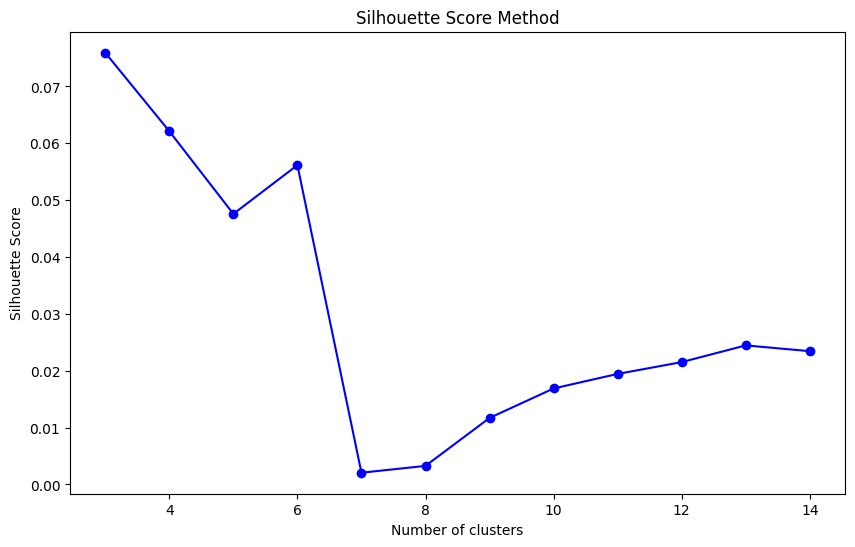

In [61]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
range_n_clusters = range(3, 15)  # Try different numbers of clusters

for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    # Use the distance matrix you already computed
    score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'b-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

### Perform Clustering & Pick nbr of clusters

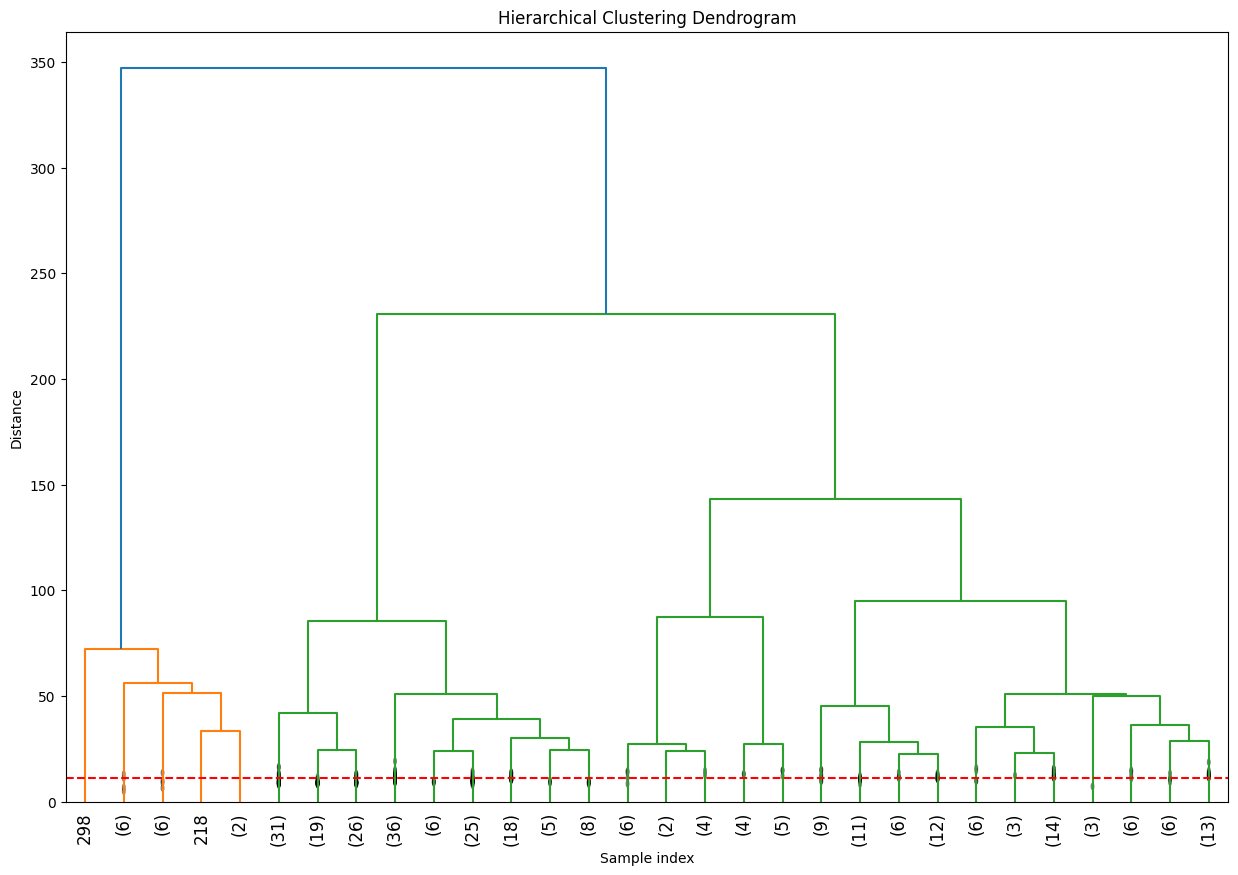

In [38]:
linkage_matrix = linkage(distance_matrix, method="ward")
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Show the last p merged clusters
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.axhline(y=np.median(linkage_matrix[:, 2]), color='r', linestyle='--')
plt.show()

To ensure the cluster is stable. We use 2 clusters.

### Label the top station's clusters

In [39]:
n_clusters = 2
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
cluster_df = pd.DataFrame({
    'station': normalized_train_highfreq.columns,
    'cluster': cluster_labels
})
cluster_df

,station,cluster
0,Streeter Dr & Grand Ave,2
1,Michigan Ave & Oak St,2
2,Wells St & Concord Ln,2
3,Millennium Park,2
4,Clark St & Elm St,2
...,...,...
295,Damen Ave & Clybourn Ave,2
296,Calumet Ave & 33rd St,2
297,Blackstone Ave & Hyde Park Blvd,2
298,Ashland Ave & Lake St,1


### Label low frequency cluster

In [40]:
tmp = train[0:0].T.reset_index()
cluster_df_full = tmp.merge(cluster_df,
              left_on="start_station_name",
              right_on="station", how="left")
cluster_df_full["cluster"] = cluster_df_full["cluster"].fillna(0).astype(int)
cluster_df_full.drop(columns=["station"], inplace=True)
cluster_df_full.rename(columns={"start_station_name":"station"})
cluster_df_full["cluster"].value_counts()

,count
cluster,
0,1779
2,284
1,16


# Cluster on 2020-2024

## Function Definition

In [104]:
def station_seg_main(year, station_pivot,top_limit=200, nbr_cluster=5,cluster_method="ward"):
  print("Preprocessing...")
  train = station_pivot.loc[f"{year}-01-01":f"{year}-12-31"]
  high_freq_stations = train.sum().sort_values(ascending=False)[:top_limit].index
  train_highfreq = train.loc[:, high_freq_stations]
  # prompt: Put low frequency station in a cluster in trainset

  print("Plotting cut-off...")
  high_freq_stations_plot = train.sum().sort_values(ascending=False)[:top_limit+100].index
  train_highfreq_plot = train.loc[:, high_freq_stations_plot]
  import matplotlib.pyplot as plt
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, len(train_highfreq_plot.columns) + 1), train_highfreq_plot.sum().sort_values(ascending=False))
  plt.yticks(range(0, int(train_highfreq_plot.sum().max()) + 10000, 10000)) # Adjust the step as needed
  plt.xlabel('Rank of Stations (Based on Total Rides)')
  plt.ylabel('Total Rides')
  plt.title('Relationship between Station Rank and Total Rides')
  plt.grid(True)
  plt.show()

  print("Normalizing...")
  # Normalize each station's time series
  means = train_highfreq.mean()
  stds = train_highfreq.std()
  normalized_train_highfreq = ((train_highfreq - means) / stds).dropna(axis=1)
  normalized_train_highfreq.head()

  print("Fitting DTW...")
  distance_matrix = dtw.distance_matrix_fast(normalized_train_highfreq.T.to_numpy(),
                        parallel=True)

  print("Clustering")
  linkage_matrix = linkage(distance_matrix, method=cluster_method)

  print("Plotting Silhouette Score")
  # Calculate silhouette scores for different numbers of clusters
  silhouette_scores = []
  range_n_clusters = range(3, 15)  # Try different numbers of clusters

  for n_clusters in range_n_clusters:
      cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
      # Use the distance matrix you already computed
      score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
      silhouette_scores.append(score)

  # Plot silhouette scores
  plt.figure(figsize=(10, 6))
  plt.plot(range_n_clusters, silhouette_scores, 'b-o')
  plt.xlabel('Number of clusters')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Score Method')
  plt.show()

  print("Plotting Dendrogram")
  plt.figure(figsize=(15, 10))
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('Sample index')
  plt.ylabel('Distance')
  dendrogram(
      linkage_matrix,
      truncate_mode='lastp',  # Show the last p merged clusters
      p=30,
      leaf_rotation=90.,
      leaf_font_size=12.,
      show_contracted=True,
  )
  plt.axhline(y=np.median(linkage_matrix[:, 2]), color='r', linestyle='--')
  plt.show()
  cluster_labels = fcluster(linkage_matrix, nbr_cluster, criterion='maxclust')
  cluster_df = pd.DataFrame({
      'station': normalized_train_highfreq.columns,
      'cluster': cluster_labels
  })
  tmp = train[0:0].T.reset_index()
  cluster_df_full = tmp.merge(cluster_df,
                left_on="start_station_name",
                right_on="station", how="left")
  cluster_df_full["cluster"] = cluster_df_full["cluster"].fillna(0).astype(int)
  cluster_df_full.drop(columns=["station"], inplace=True)
  cluster_df_full.rename(columns={"start_station_name":"station"})
  cluster_df_full["cluster"].value_counts()
  cluster_df_full.to_csv(
    f"/content/drive/Shared drives/Time Series/Notebooks/Modeling/modeling_andy/clusters/cluster_df_{year}_{nbr_cluster}clusters_{top_limit}toplimit_{cluster_method}.csv",
    index=False)
  return cluster_df_full, linkage_matrix, distance_matrix

## 2020

Preprocessing...
Plotting cut-off...


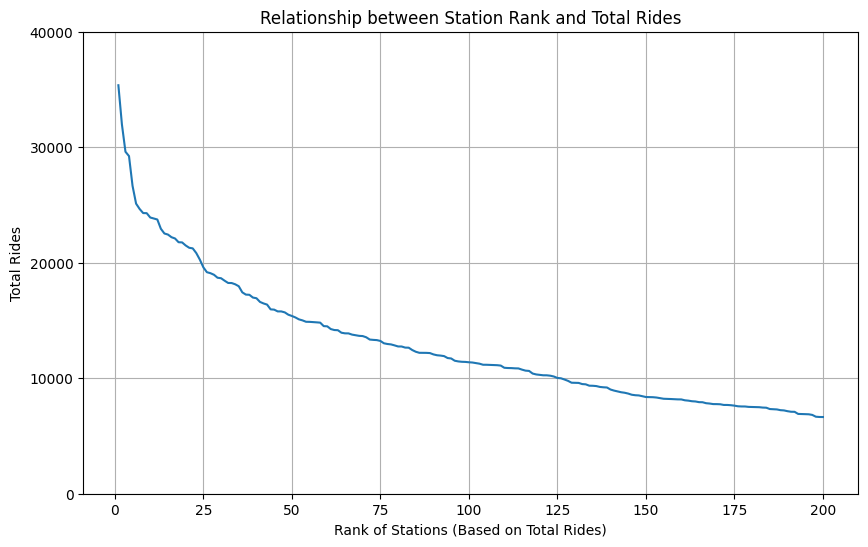

Normalizing...
Fitting DTW...
Clustering
Plotting Silhouette Score


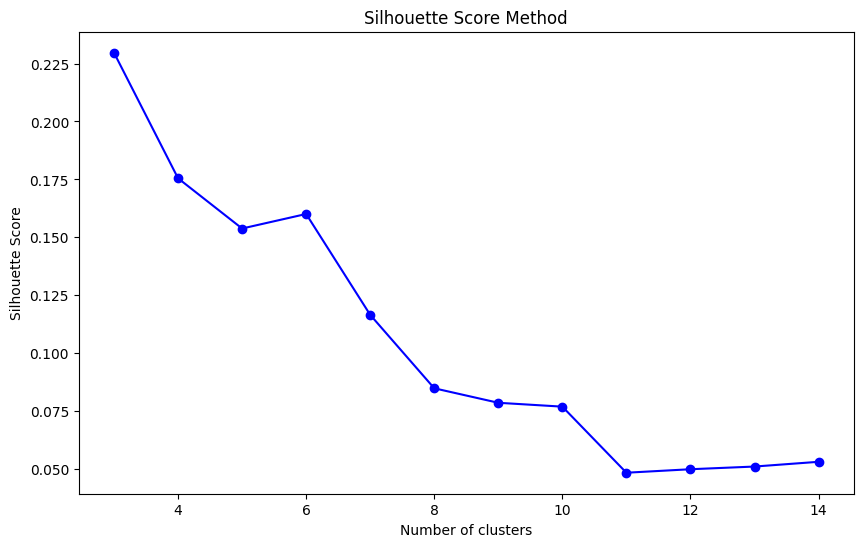

Plotting Dendrogram


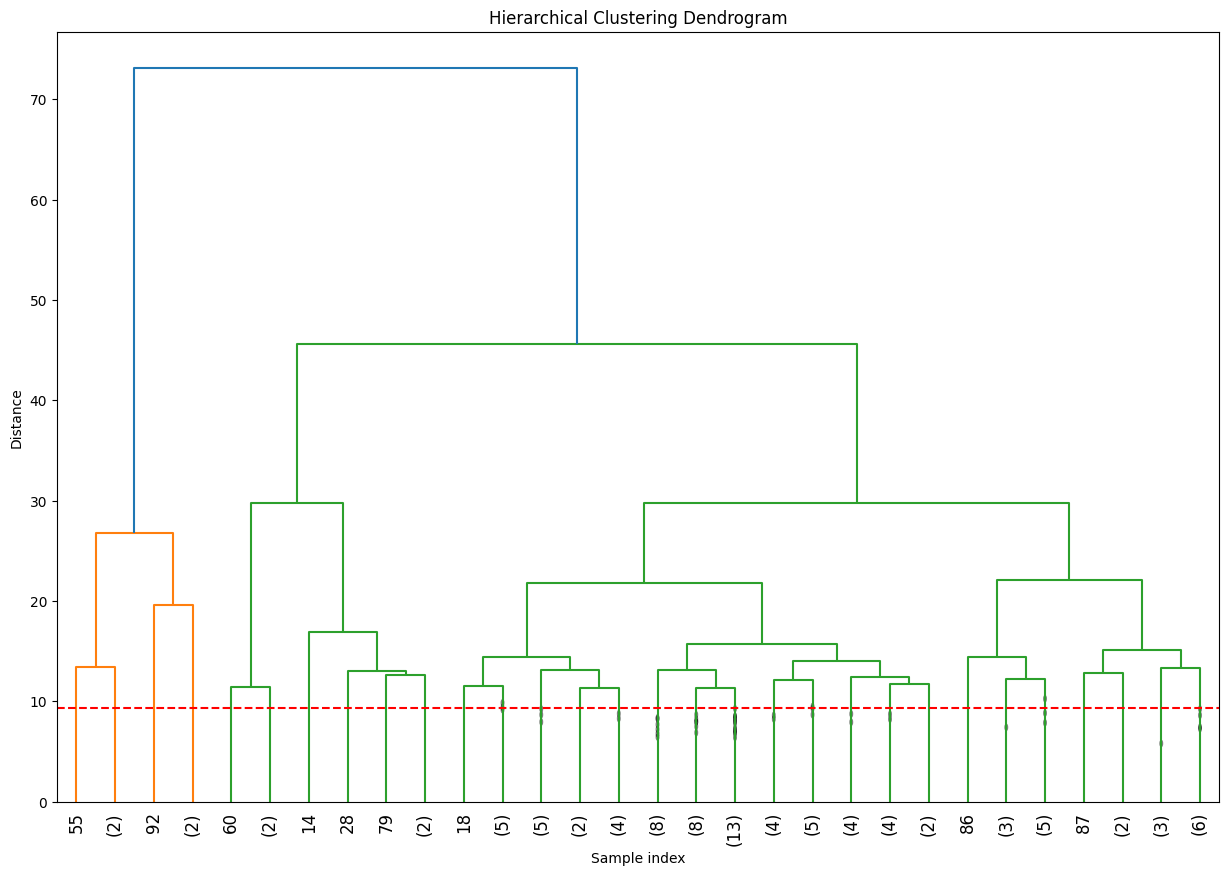

In [105]:
cluster_df_full_2020, linkage_matrix_2020, distance_matrix_2020 = station_seg_main(2020, station_pivot,top_limit=100,nbr_cluster=5,cluster_method="complete")

## 2021

Preprocessing...
Plotting cut-off...


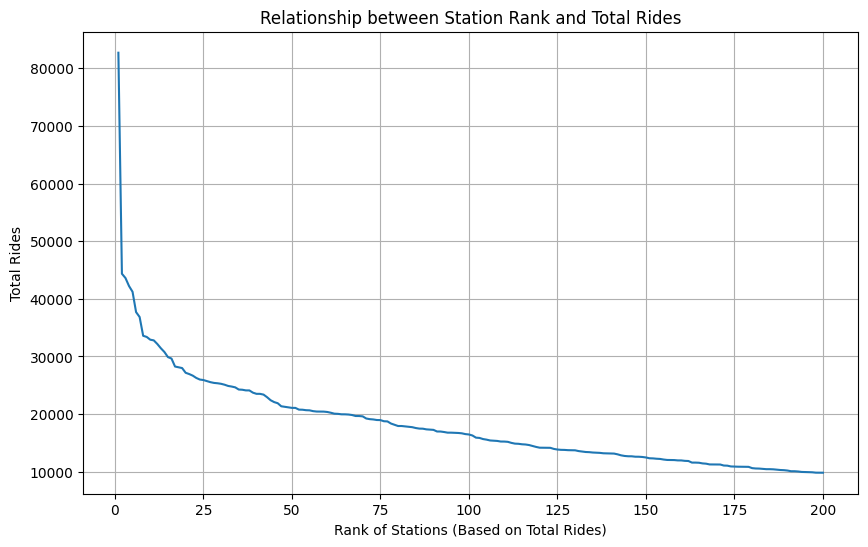

Normalizing...
Fitting DTW...
Clustering
Plotting Silhouette Score


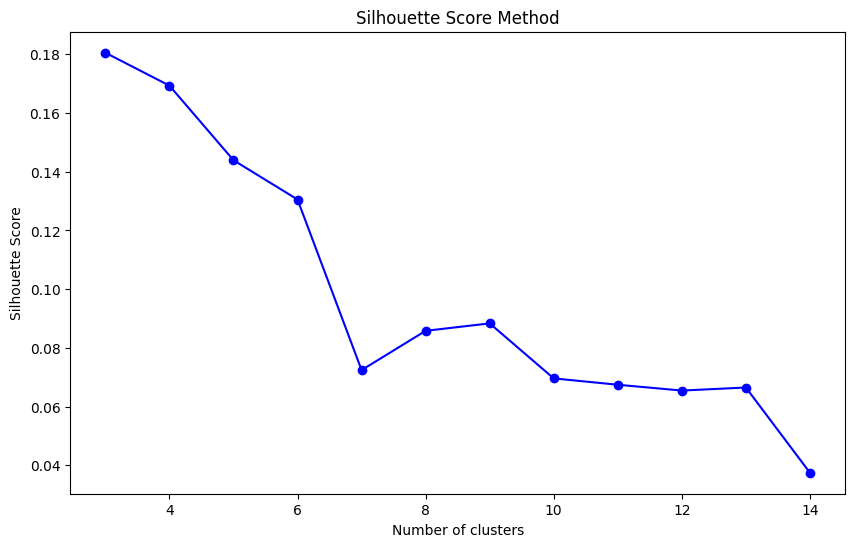

Plotting Dendrogram


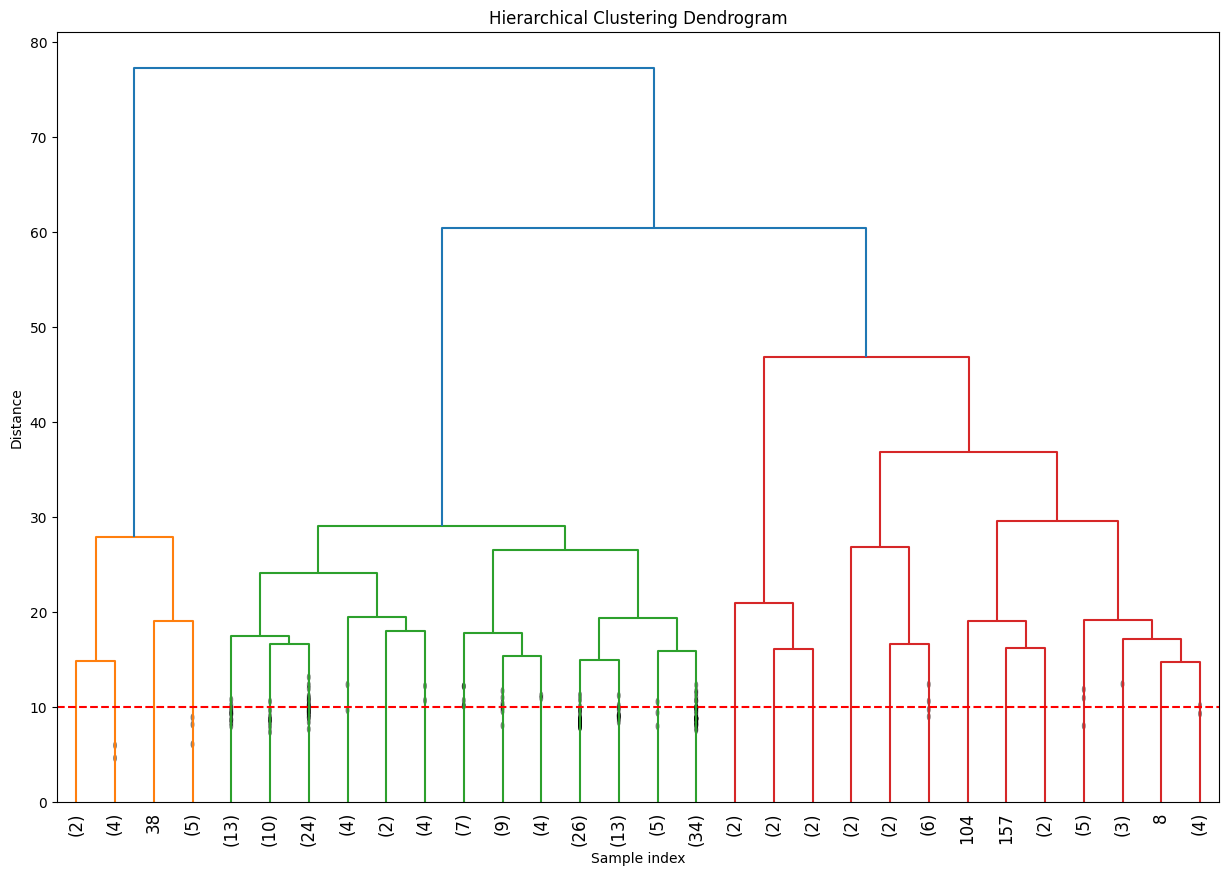

In [95]:
cluster_df_full_2021, linkage_matrix_2021, distance_matrix_2021 = station_seg_main(2021, station_pivot,top_limit=200,nbr_cluster=5,cluster_method="complete")

## 2022

Preprocessing...
Plotting cut-off...


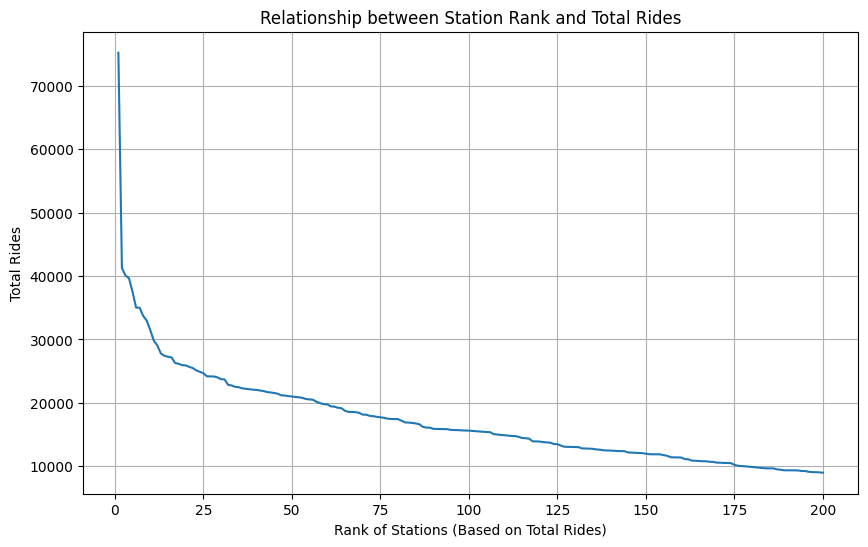

Normalizing...
Fitting DTW...
Clustering
Plotting Silhouette Score


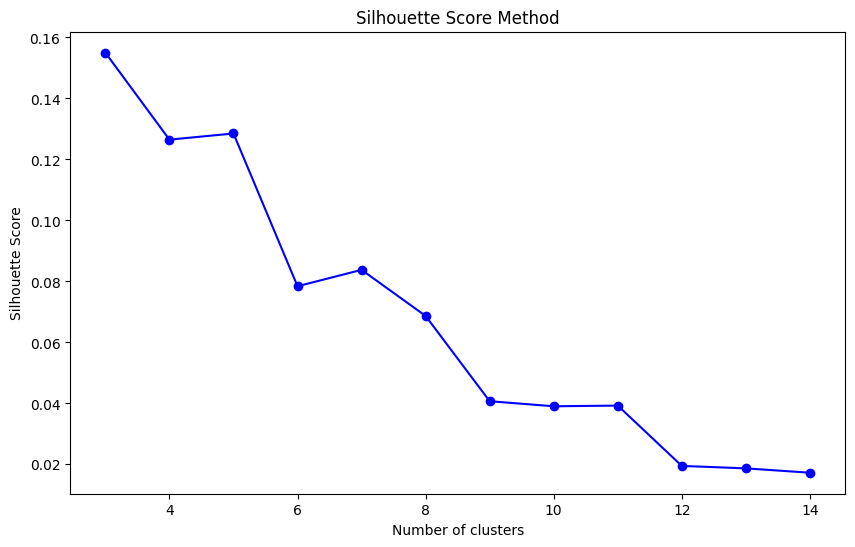

Plotting Dendrogram


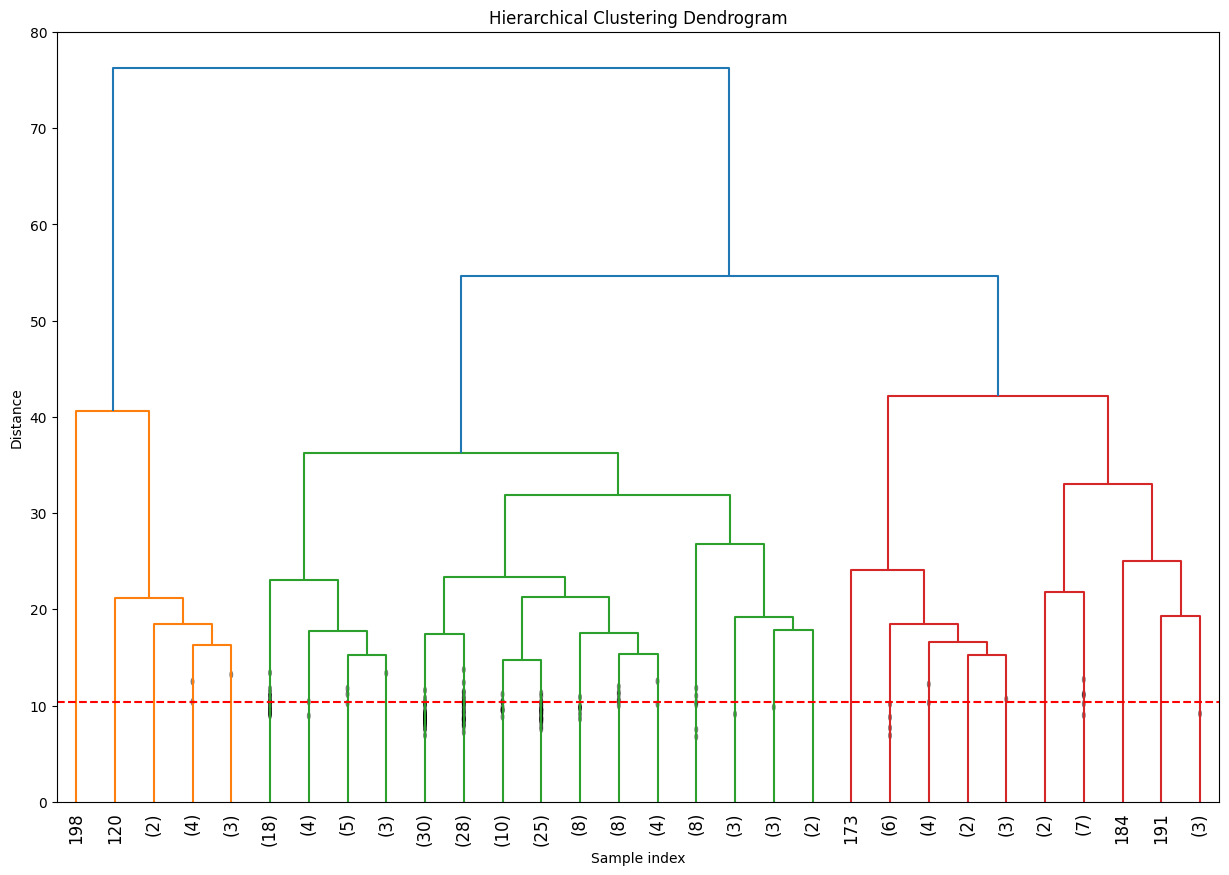

In [86]:
cluster_df_full_2022, linkage_matrix_2022, distance_matrix_2022 = station_seg_main(2022, station_pivot,top_limit=200,nbr_cluster=5,cluster_method="complete")

## 2023

Preprocessing...
Fitting DTW...
Clustering
Plotting Silhouette Score


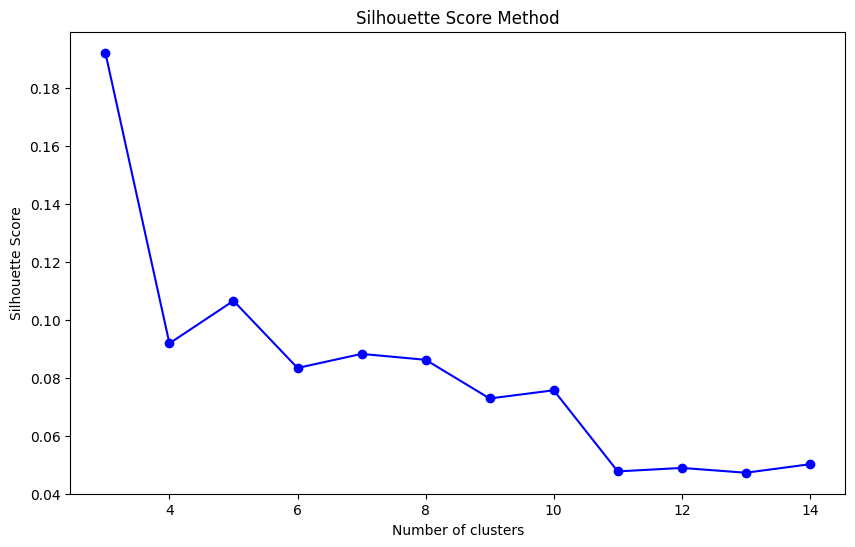

Plotting Dendrogram


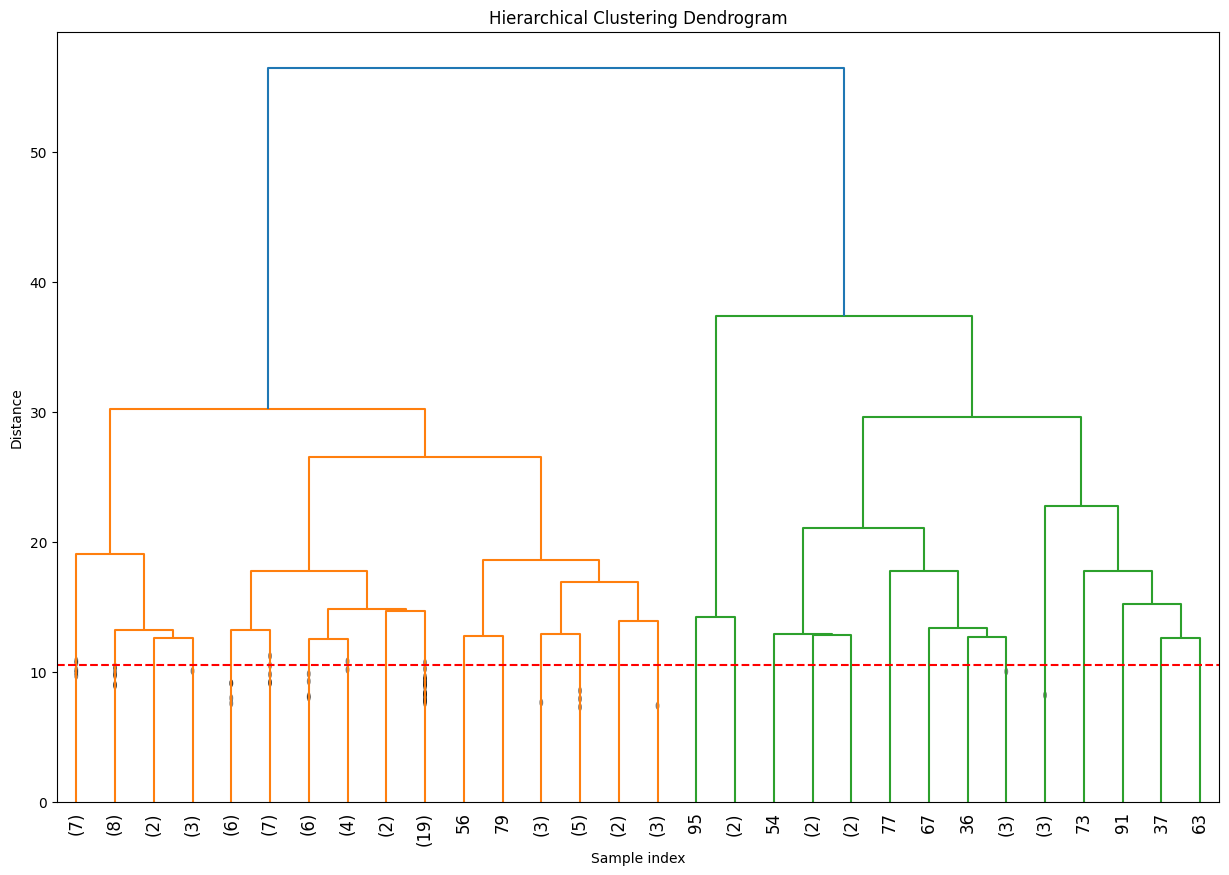

In [70]:
cluster_df_full_2023, linkage_matrix_2023, distance_matrix_2023 = station_seg_main(2023, station_pivot,top_limit=100,nbr_cluster=5,cluster_method="complete")

## 2024

Preprocessing...
Fitting DTW...
Clustering
Plotting Silhouette Score


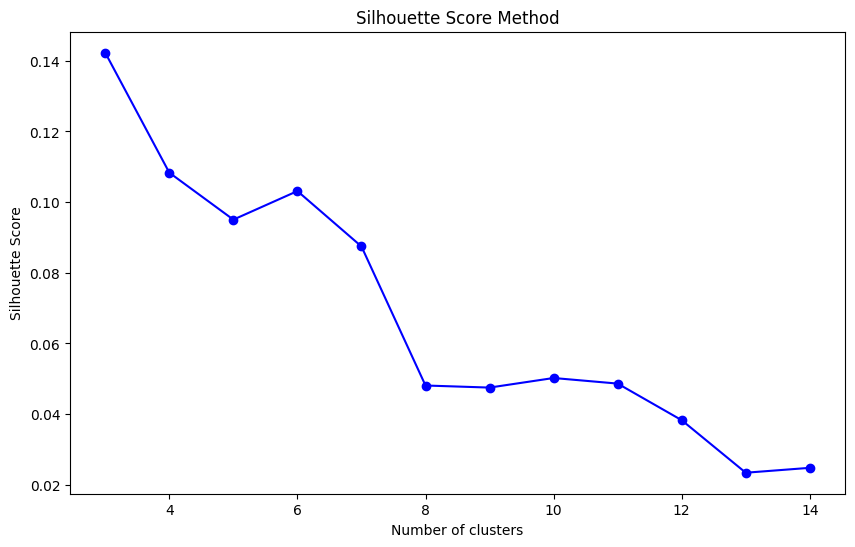

Plotting Dendrogram


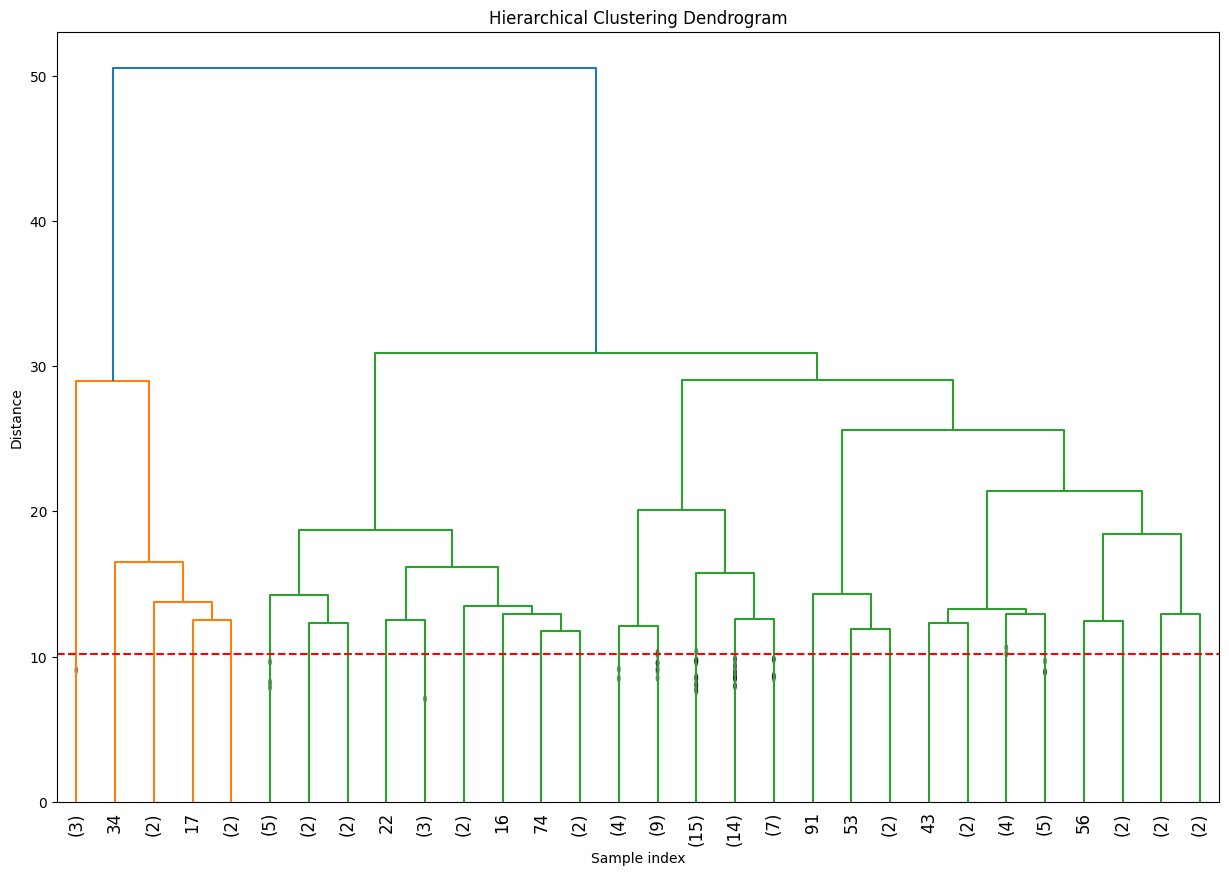

In [71]:
df_2024 = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_station_test.csv")
station_df_2024 = df_2024[["date", "start_station_name", "total_rides"]].groupby(["date", "start_station_name"]).sum().reset_index()
station_pivot_2024 = station_df_2024.pivot(index='date', columns='start_station_name', values='total_rides').fillna(0)
cluster_df_full_2024, linkage_matrix_2024, distance_matrix_2024 = station_seg_main(2024, station_pivot_2024,top_limit=100,nbr_cluster=5,cluster_method="complete")